In [1]:
import matplotlib.pyplot as plt
import numpy as np

from microlensing.IPM.ipm import IPM
from microlensing.CCF.ccf import CCF
from microlensing.NCC.ncc import NCC

# Creating a magnification map

In [2]:
# calculating critical curves depends on the number of stars used
# we therefore set rectangular=True to avoid using a circular field with a larger number of stars
# we set approx=True to approximate the smooth deflection angle alpha_smooth with a Taylor series,
# as exact calculations involve transcendental functions for which we cannot guarantee all the
# critical curves have been located
 
ipm = IPM(verbose=1, 
          kappa_tot=0.4, shear=0.4, smooth_fraction=0.5, 
          rectangular=True, approx=True,
          half_length_y1=5, half_length_y2=5,
          num_pixels_y1=1000, num_pixels_y2=1000,
          write_stars=True) # we will also want to write the stars to disk

ipm.random_seed = 0 # setting to 0 will cause object to generate a random seed of its own
ipm.run()
ipm.save() # save stars to disk to use for finding caustics

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.107 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.091 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 1.18 seconds.

Done writing parameter info to file ./ipm_parameter_info.txt
Done writing star info to file ./ipm_stars.bin


# Locating critical curves and caustics

In [3]:
ccf = CCF(verbose=1, 
          kappa_tot=ipm.kappa_tot, shear=ipm.shear, 
          starfile=f'{ipm.outfile_prefix}ipm_stars.bin',
          num_phi=200, # number of steps for the phase parameter phi that traces the critical curves
          write_caustics=True) # by default only critical curves are calculated, so set true to map them to caustics as well
ccf.run()
ccf.save()

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.067 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.099 seconds.

Finding initial roots...
[==================================================] 100 %
Done finding initial roots. Elapsed time: 0.03 seconds.
Maximum error in 1/mu: 9.84069e-10

Finding critical curve positions...
[==================================================] 100 %
Done finding critical curve positions. Elapsed time: 0.575 seconds.
Maximum error in 1/mu: 9.99375e-10

Done writing parameter info to file ./ccf_parameter_info.txt
Done writing caustic positions to file ./ccf_caustics.bin


# Calculate number of caustic crossings

In [4]:
ncc = NCC(verbose=1, infile_prefix=ccf.outfile_prefix, # for reading in the caustics
          # the following 3 lines are to match magnification map parameters
          center_y1=ipm.center_y1, center_y2=ipm.center_y2, 
          half_length_y1=ipm.half_length_y1, half_length_y2=ipm.half_length_y2,
          num_pixels_y1=ipm.num_pixels_y1, num_pixels_y2=ipm.num_pixels_y2)

In [5]:
ncc.run()

Reading in caustics...
Done reading in caustics. Elapsed time: 0.053 seconds.

Calculating number of caustic crossings...
100 %
Done calculating number of caustic crossings. Elapsed time: 0.081 seconds.

Downsampling number of caustic crossings...
Done downsampling number of caustic crossings. Elapsed time: 0.032 seconds.



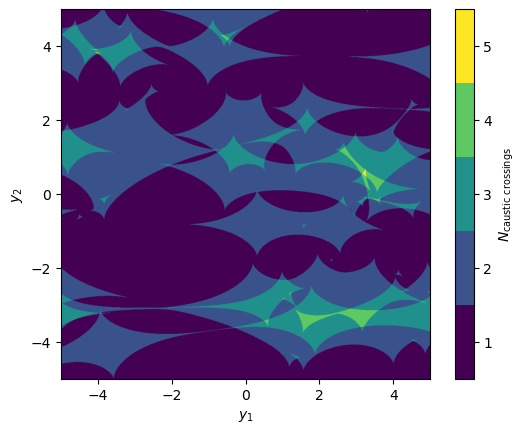

In [6]:
# plot number of caustic crossings
fig, ax = plt.subplots()
ncc.plot_map(ax)
plt.show()

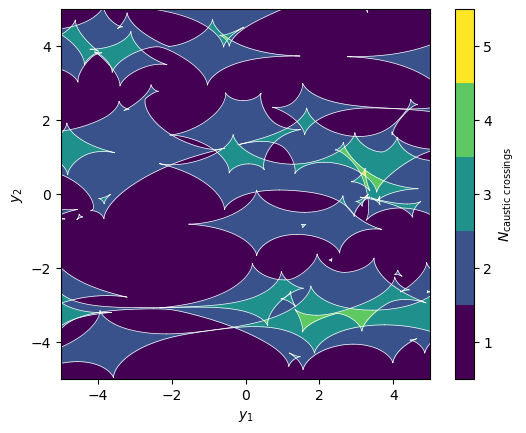

In [7]:
# plot caustics as well
fig, ax = plt.subplots()
ccf.plot_caustics(ax, color='white', linewidth=0.5)
ncc.plot_map(ax)
ax.set_xlim([-ipm.half_length[0], ipm.half_length[0]])
ax.set_ylim([-ipm.half_length[1], ipm.half_length[1]])
ax.set_aspect(ipm.half_length[0] / ipm.half_length[1])
plt.show()

# Calculating distances

In [8]:
from microlensing.NCC import distances

In [9]:
d_caustic = distances.expanding_source(ncc)

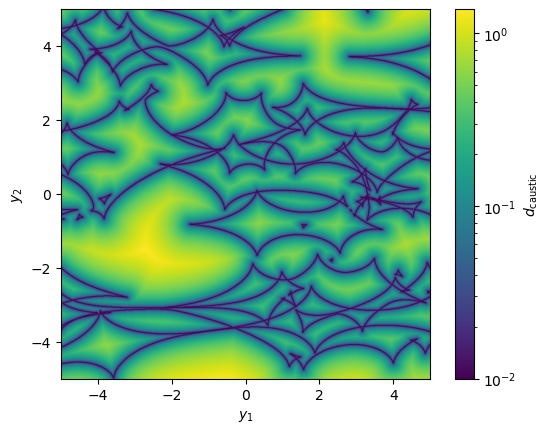

In [10]:
fig, ax = plt.subplots()

img = ax.imshow(d_caustic, 
                extent=[-ncc.half_length_y1, ncc.half_length_y1, 
                        -ncc.half_length_y2, ncc.half_length_y2],
                cmap='viridis', norm='log')

ax.set_xlim([-ncc.half_length_y1, ncc.half_length_y1])
ax.set_ylim([-ncc.half_length_y2, ncc.half_length_y2])
ax.set_aspect(ncc.half_length_y2 / ncc.half_length_y1)
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')

fig.colorbar(img, label='$d_{\\text{caustic}}$')

plt.show()

In [11]:
angle = 20 # source moving at an angle of 20 degrees relative to the positive y1 axis
d_caustic = distances.moving_source(ncc, angle)

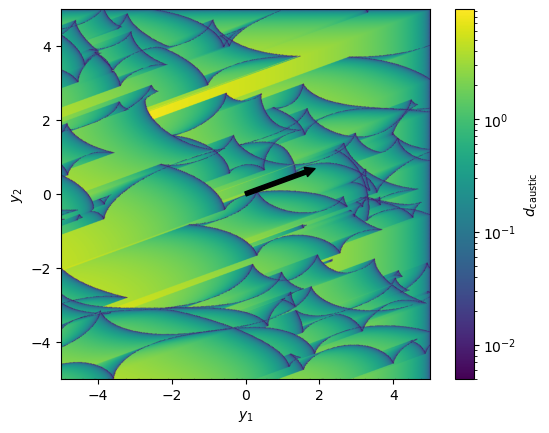

In [12]:
fig, ax = plt.subplots()

img = ax.imshow(d_caustic, 
                extent=[-ncc.half_length_y1, ncc.half_length_y1, 
                        -ncc.half_length_y2, ncc.half_length_y2],
                cmap='viridis', norm='log')

ax.annotate("", xytext=(0, 0), 
            xy=2 * np.array([np.cos(np.radians(angle)), np.sin(np.radians(angle))]),
            arrowprops={'width': 3, 'color': 'black', 'headlength': 7, 'headwidth': 7})

ax.set_xlim([-ncc.half_length_y1, ncc.half_length_y1])
ax.set_ylim([-ncc.half_length_y2, ncc.half_length_y2])
ax.set_aspect(ncc.half_length_y2 / ncc.half_length_y1)
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')

fig.colorbar(img, label='$d_{\\text{caustic}}$')

plt.show()